# Biomarker Prediction Pipeline (SY)

This pipeline consists of data preprocessing, feature selection, selection of machine learning models, and model evaluation. 

In [1]:
import os 
import DataFunctions as utils
import Visualisation as vis
from toolkit import * 
import numpy as np
import pandas as pd
### Load data

import pandas as pd
import pickle

# import GDSC2 drug response data using pickle

with open('data/drug-response/GDSC2/cache_gdsc2.pkl', 'rb') as f:
    gdsc2 = pickle.load(f)
    gdsc2_info = pickle.load(f)

# import CCLE gene expression data using pickle

with open('data/gene-expression/CCLE_Public_22Q2/ccle_expression.pkl', 'rb') as f:
    gene_entrez = pickle.load(f)
    ccle = pickle.load(f)

# import CCLE sample info data using pickle

with open('data/gene-expression/CCLE_Public_22Q2/ccle_sample_info.pkl', 'rb') as f:
    ccle_sample_info = pickle.load(f)

# import STRING database using pickle

with open('data/protein-interaction/STRING/string_df.pkl', 'rb') as f:
    string_df = pickle.load(f)
    string_df_info = pickle.load(f)
    string_df_alias = pickle.load(f)


# import proteomic expression
with open('data/proteomic-expression/goncalves-2022-cell/goncalve_proteome_processed.pkl', 'rb') as f:
    joined_full_protein_matrix = pickle.load(f)
    joined_sin_peptile_exclusion_matrix = pickle.load(f)

# import STRING database using pickle

with open('data/protein-interaction/STRING/string_df.pkl', 'rb') as f:
    string_df = pickle.load(f)
    string_df_info = pickle.load(f)
    string_df_alias = pickle.load(f)

# open STRING to goncalves mapping file

with open('data\protein-interaction\STRING\goncalve_to_string_id_df.pkl', 'rb') as f:
    goncalve_to_string_id_df = pickle.load(f)

# open the cache for neighbourhood calculations

with open('data/protein-interaction/STRING/palbociclib_nth_degree_neighbours.pkl', 'rb') as f:
    nth_degree_neighbours = pickle.load(f)


c:\Github\ode-biomarker-project\dynamic-marker\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preprocessing

In [2]:
# create the full dataset
drug_selected = 'Palbociclib'
target_variable = 'AUC'
imputation_method = 'FirstQuantile' # or "Zero"

data_df = utils.create_joint_dataset_from_proteome_gdsc(drug_selected, joined_sin_peptile_exclusion_matrix, gdsc2, drug_value=target_variable)
if imputation_method == 'FirstQuantile':
    imputer = FirstQuantileImputer()
    imputer.fit(data_df)
    # transform the data
    data_df = imputer.transform(data_df, return_df=True)
elif imputation_method == 'Zero':
    data_df.fillna(0, inplace=True)

feature_data, label_data = utils.create_feature_and_label(data_df, label_name=target_variable)

In [3]:
feature_data.head()

,P37108;SRP14_HUMAN,Q96JP5;ZFP91_HUMAN,Q9Y4H2;IRS2_HUMAN,P36578;RL4_HUMAN,Q6SPF0;SAMD1_HUMAN,O76031;CLPX_HUMAN,Q8WUQ7;CATIN_HUMAN,A6NIH7;U119B_HUMAN,Q9BTD8;RBM42_HUMAN,Q9P258;RCC2_HUMAN,...,P33151;CADH5_HUMAN,Q5EBL4;RIPL1_HUMAN,P49715;CEBPA_HUMAN,Q5TA45;INT11_HUMAN,O14924;RGS12_HUMAN,Q7Z3B1;NEGR1_HUMAN,O60669;MOT2_HUMAN,Q13571;LAPM5_HUMAN,Q96JM2;ZN462_HUMAN,P35558;PCKGC_HUMAN
SIDM00042,5.70786,0.960009,1.606772,6.22574,0.367491,4.49579,0.799552,1.589653,2.87981,3.531698,...,1.667301,1.038525,1.451557,0.249701,0.989563,1.084006,0.478142,0.429040,1.743989,1.274829
SIDM00044,6.04591,3.693560,1.134462,7.07092,3.495940,4.05438,0.332476,1.647171,3.44202,4.342370,...,0.802372,3.022600,2.568359,1.103296,0.570150,0.565432,2.169520,2.405946,2.393854,2.793764
SIDM00045,6.20582,2.881180,1.843512,8.25336,3.354390,5.09923,0.331375,1.133451,3.56256,6.010810,...,0.342107,1.263013,2.101498,0.402212,0.517273,0.999801,0.957451,0.418518,1.767420,1.409381
SIDM00047,6.80469,2.787370,0.494899,7.58653,2.149800,5.43356,0.177694,3.508080,3.43601,5.122330,...,1.406246,1.327355,0.332983,0.388459,1.038627,1.236828,1.233406,2.406391,1.264796,0.248496
SIDM00049,6.28591,0.884041,2.114200,6.98525,3.529120,4.74122,0.573411,0.900324,3.51710,5.813590,...,2.705457,0.417259,1.751877,1.377022,0.073790,1.271438,0.757511,1.200660,1.146696,2.602734


In [4]:
label_data.head()

SIDM00042    0.972795
SIDM00044    0.859575
SIDM00045    0.708765
SIDM00047    0.915499
SIDM00049    0.925833
Name: AUC, dtype: float64

## Feature Selection

In [5]:
'''
SY: a feature selection method based on statistically significant pearson correlation with the target variable, using the full dataset..
'''

'\nSY: a feature selection method based on statistically significant pearson correlation with the target variable, using the full dataset..\n'

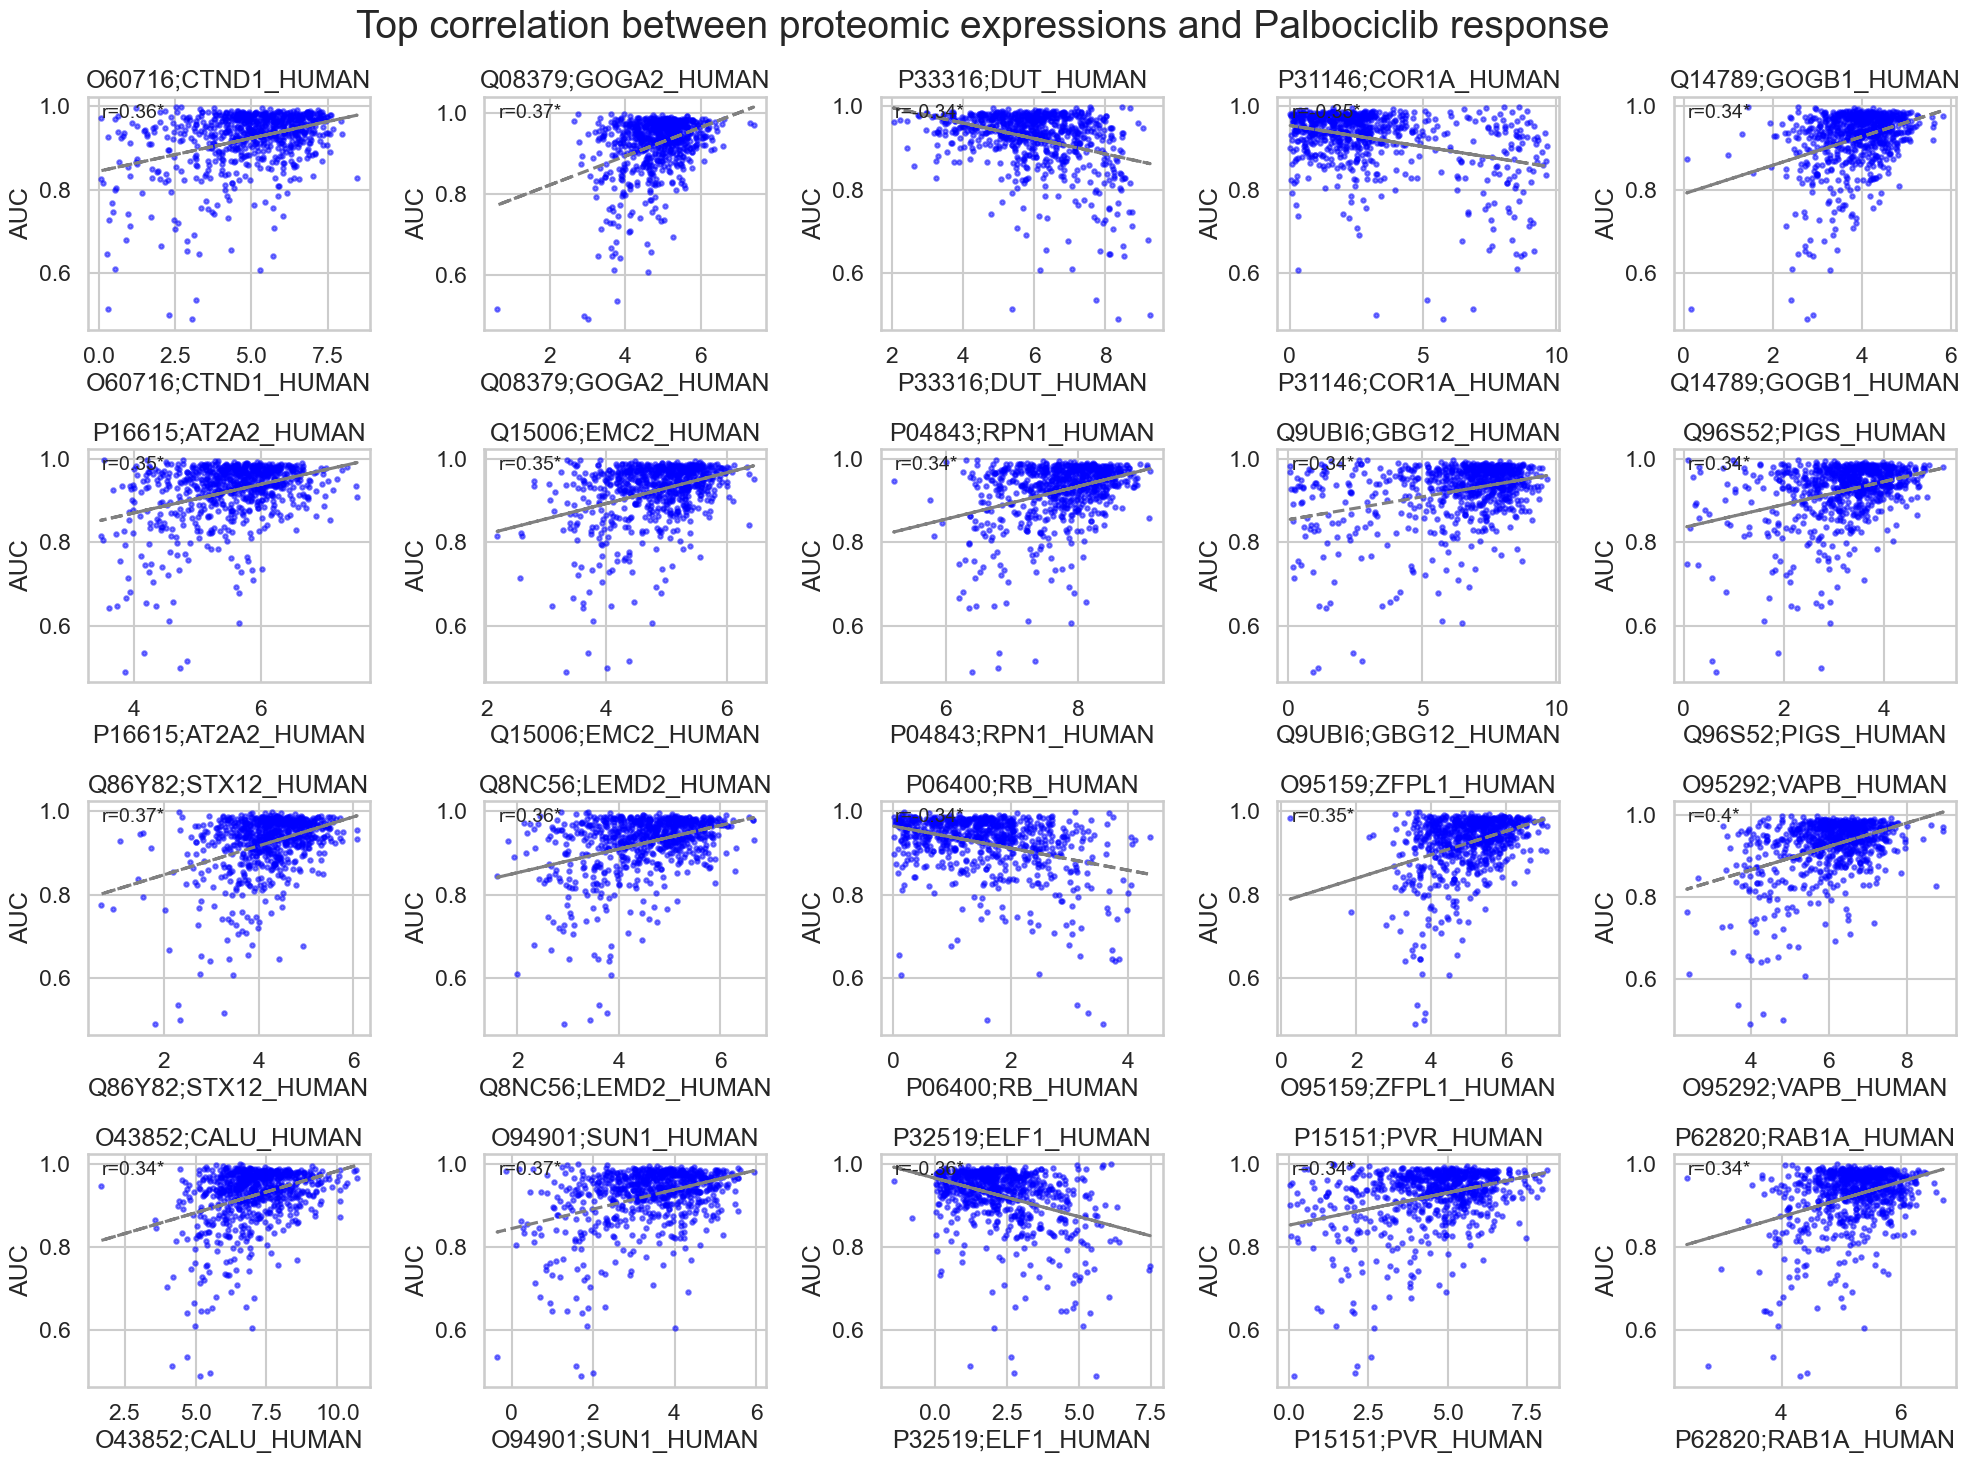

In [6]:
# a casual plot..

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
sns.set_context('talk')

# select the top 20 features
selector = SelectKBest(f_regression, k=20)
selector.fit(feature_data, label_data)

# get the names of the top 20 features return index = true
top_20_features_original = feature_data.columns[selector.get_support(indices=True)]

fig, axes = plt.subplots(4, 5, figsize=(20, 15))
for i, ax in enumerate(axes.flatten()):
    # create a joint dataframe of gene expression and drug response for palbociclib
    # print(top_20_features[i])
    feature = top_20_features_original[i]
    ax = vis.plot_correlation(data_df, feature, 'AUC', ax, title=f'{feature}',
                          color='blue', alpha=0.5, s=10)

fig.suptitle('Top correlation between proteomic expressions and Palbociclib response', fontsize=28)
plt.tight_layout()
plt.show()

In [7]:

# for each column in the feature data, calculate the pearson correlation coefficient with the target variable

pearson_correlation_coefficients = []
p_values = []

for feature in feature_data.columns:
    pearson_correlation_coefficient, p_value = pearsonr(feature_data[feature], label_data)
    pearson_correlation_coefficients.append(pearson_correlation_coefficient)
    p_values.append(p_value)

# create a dataframe of the pearson correlation coefficients and p-values

pearson_correlation_coefficients_df = pd.DataFrame({'feature': feature_data.columns,
                                                    'pearson_correlation_coefficient': pearson_correlation_coefficients,
                                                    'p_value': p_values})

# sort the dataframe by the absolute value of the pearson correlation coefficient

pearson_correlation_coefficients_df = pearson_correlation_coefficients_df.reindex(pearson_correlation_coefficients_df['pearson_correlation_coefficient'].abs().sort_values(ascending=False).index)

# show df 

pearson_correlation_coefficients_df.head()

,feature,pearson_correlation_coefficient,p_value
3771,O95292;VAPB_HUMAN,0.401822,5.707279e-30
4281,O94901;SUN1_HUMAN,0.371526,1.542404e-25
193,Q08379;GOGA2_HUMAN,0.369240,3.191134e-25
3143,Q86Y82;STX12_HUMAN,0.367106,6.261125e-25
4352,P32519;ELF1_HUMAN,-0.361884,3.186380e-24


95% confidence interval: -0.12072773065557021, 0.12166197753069795


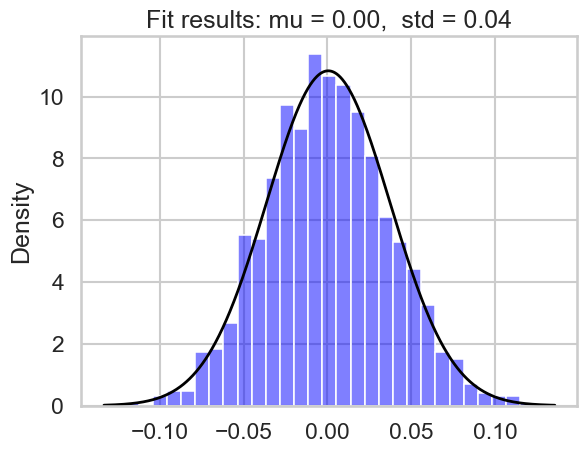

In [26]:
# import norm 

from scipy.stats import norm

def sampling_pearson(feature_data: pd.DataFrame, label_data: pd.Series, feature_name: str, sample_size: int = 100):
    
    all_pearson_r = []
    all_p_value = []

    for i in range(sample_size):
        # get the original data
        # randomly shuffle the data
        shuffled_data = feature_data[feature_name].sample(frac=1).reset_index(drop=True)

        pearson_r, p_value = pearsonr(shuffled_data, label_data)
        # print(f'Pearson correlation coefficient: {pearson_r}, p-value: {p_value}')
        all_pearson_r.append(pearson_r)
        all_p_value.append(p_value)

    return all_pearson_r, all_p_value

r, p = sampling_pearson(feature_data, label_data, 'O95292;VAPB_HUMAN', sample_size=1500)


sns.histplot(r, stat='density', color='blue', alpha=0.5)

# fit a normal distribution

mu, std = norm.fit(r)

# plot the pdf

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)


ci_lower, ci_upper = norm.interval(0.999, loc=mu, scale=std)
print(f'95% confidence interval: {ci_lower}, {ci_upper}')
